In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import roc_curve, auc, mean_squared_error
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD


In [7]:
rd = pd.read_csv(df+"ratings.csv",index_col = 0)

In [9]:
rd

,userId,movieId,rating,timestamp
0,496,112852,3.0,1415520462
1,391,1947,4.0,1030945141
2,387,1562,1.5,1095041022
3,474,2716,4.5,1053020930
4,483,88125,4.5,1311337237
...,...,...,...,...
100831,469,1219,4.0,965661925
100832,599,3571,2.0,1498511343
100833,414,276,3.0,961596299
100834,395,168,3.0,841503984


In [10]:
from pathlib import Path  
filepath = Path('/content/drive/MyDrive/out1.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
rd.to_csv(filepath,index = False)  

In [11]:
reader = Reader(line_format='user item rating timestamp',sep=',',rating_scale=(0.5, 5),skip_lines=1)
ratings_dataset = Dataset.load_from_file('/content/drive/MyDrive/out1.csv',reader = reader)

In [12]:
df = '/content/drive/MyDrive/Synthetic_Movie_Lens/'
Ratings_file = pd.read_csv(df+"ratings.csv",usecols=['userId','movieId','rating']) 

## Question 8A) 

In [13]:
k = np.arange(2,52,2)
rmse_NMF = []
mae_NMF = []
for item in k:
    print('Testing for k =',item)
    res = cross_validate(NMF(n_factors=item,n_epochs=50,verbose=False),
                         measures=['rmse','mae'],data = ratings_dataset,cv=10,n_jobs=-1)   
    rmse_NMF.append(np.mean(res['test_rmse']))
    mae_NMF.append(np.mean(res['test_mae']))

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50


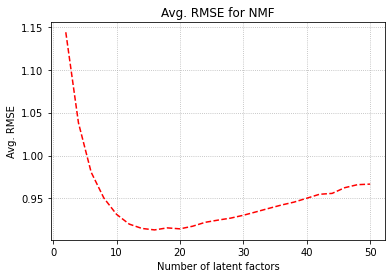

In [16]:
plt.plot(k,rmse_NMF,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('Average RMSE for NMF')
plt.ylabel('Average RMSE')
plt.xlabel('Number of latent factors')
plt.savefig('Q8a.png',dpi=300,bbox_inches='tight')
plt.show()

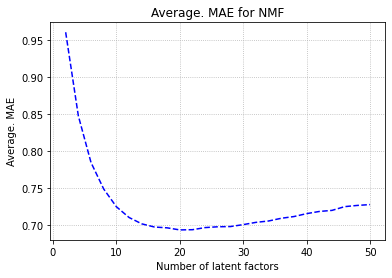

In [17]:
plt.plot(k,mae_NMF,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('Average MAE for NMF')
plt.ylabel('Average MAE')
plt.xlabel('Number of latent factors')
plt.savefig('Q8b.png',dpi=300,bbox_inches='tight')
plt.show()

In [19]:
print("Minimum average RMSE (NMF): %f, value of k: %d" % (min(rmse_NMF),k[[i for i, x in enumerate(rmse_NMF) if x == min(rmse_NMF)][0]]))
print("Minimum average MAE (NMF): %f, value of k: %d" % (min(mae_NMF),k[[i for i, x in enumerate(mae_NMF) if x == min(mae_NMF)][0]]))

Minimum average RMSE (NMF): 0.913185, value of k: 16
Minimum average MAE (NMF): 0.693954, value of k: 20


## NMF Popular 

In [20]:
rmse_NMF_pop = []
kf =  KFold(n_splits=10)
for item in k:
    local_rmse = []
    print('Testing for k =',item)
    for trainset, testset in kf.split(ratings_dataset):
        trim_list = []
        unique, counts = np.unique([row[1] for row in testset], return_counts=True)
        for i in range(len(counts)):
            if(counts[i]<=2):
                trim_list.append(unique[i])
        trimmed_set = [j for j in testset if j[1] not in trim_list]
        res = NMF(n_factors=item,n_epochs=50,verbose=False).fit(trainset).test(trimmed_set)
        local_rmse.append(accuracy.rmse(res,verbose=False))
    rmse_NMF_pop.append(np.mean(local_rmse))

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50


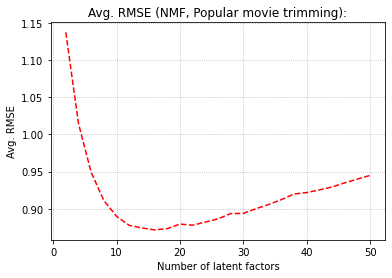

In [21]:
plt.plot(k,rmse_NMF_pop,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (NMF, Popular movie trimming):')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of latent factors')
plt.savefig('Q19.png',dpi=300,bbox_inches='tight')
plt.show()

In [22]:
print("Minimum avg. RMSE (NMF, Popular movie trimming):", min(rmse_NMF_pop))

Minimum avg. RMSE (NMF, Popular movie trimming): 0.8714131776094269


## NMF High Variance

In [23]:
rmse_NMF_var = []
kf =  KFold(n_splits=10)
dict_of_items = {}
for j in ratings_dataset.raw_ratings:
    if j[1] in dict_of_items.keys():
        dict_of_items[j[1]].append(j[2])
    else:
        dict_of_items[j[1]] = []
        dict_of_items[j[1]].append(j[2])

for item in k:
    local_rmse = []
    print('Testing for k =',item)
    for trainset, testset in kf.split(ratings_dataset):
        trimmed_set = [j for j in testset if (np.var(dict_of_items[j[1]]) >= 2 and len(dict_of_items[j[1]]) >= 5)]
        res = NMF(n_factors=item,n_epochs=50,verbose=False).fit(trainset).test(trimmed_set)
        local_rmse.append(accuracy.rmse(res,verbose=False))
    rmse_NMF_var.append(np.mean(local_rmse))

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50


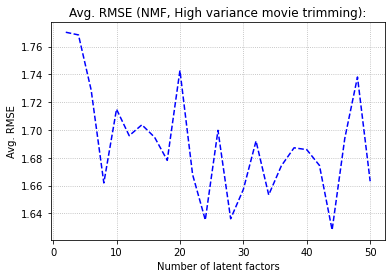

In [24]:
plt.plot(k,rmse_NMF_var,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (NMF, High variance movie trimming):')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of latent factors')
plt.savefig('Q21.png',dpi=300,bbox_inches='tight')
plt.show()

In [25]:
print("Minimum avg. RMSE (NMF, High variance movie trimming):", min(rmse_NMF_var))

Minimum avg. RMSE (NMF, High variance movie trimming): 1.6281513668856529


## Question 8C

In [26]:
k = k[[i for i, x in enumerate(rmse_NMF) if x == min(rmse_NMF)][0]]
thres = [2.5, 3.0, 3.5, 4.0]
trainset, testset = train_test_split(ratings_dataset, test_size=0.1)
res  = NMF(n_factors=k,n_epochs=50,verbose=False).fit(trainset).test(testset)

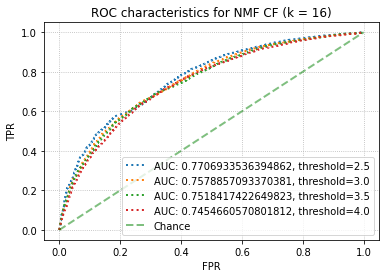

In [27]:
fig, ax = plt.subplots()
for item in thres:
    thresholded_out = []
    for row in res:
        if row.r_ui > item:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(item))  
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)  
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for NMF CF (k = 16)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.savefig('Q22.png',dpi=300,bbox_inches='tight')
plt.show() 

## Question 11 - Naive Collab Filtering

In [28]:
user_ID = Ratings_file.pop('userId').values
movie_ID = Ratings_file.pop('movieId').values
rating = Ratings_file.pop('rating').values
sparsity = len(rating)/(len(set(movie_ID))*len(set(user_ID)))
print('Sparsity:',sparsity)

Sparsity: 0.016999683055613623


In [29]:
user_ID_set = list(set(user_ID))
mean_ratings = []
for user in user_ID_set:
    idx = np.where(user_ID == user)
    mean_ratings.append(np.mean(rating[idx]))


In [30]:
kf = KFold(n_splits=10)
local_rmse = []
for trainset, testset in kf.split(ratings_dataset):
    res = [mean_ratings[int(row[0])-1] for row in testset]
    gt = [row[2] for row in testset]
    local_rmse.append(mean_squared_error(gt,res,squared=False))
rmse_naive = np.mean(local_rmse)


In [31]:
print('Avg. RMSE for Naive Filtering: ',rmse_naive)


Avg. RMSE for Naive Filtering:  0.9347087085691561


In [32]:
local_rmse_naive_unpop = []
kf =  KFold(n_splits=10)
for trainset, testset in kf.split(ratings_dataset):
    trim_list = []
    unique, counts = np.unique([row[1] for row in testset], return_counts=True)
    for i in range(len(counts)):
        if(counts[i]>2):
            trim_list.append(unique[i])
    trimmed_set = [j for j in testset if j[1] not in trim_list]
    res = [mean_ratings[int(row[0])-1] for row in trimmed_set]
    gt = [row[2] for row in trimmed_set]
    local_rmse_naive_unpop.append(mean_squared_error(gt,res,squared=False))
rmse_naive_unpop = np.mean(local_rmse_naive_unpop)

In [33]:
print('Avg. RMSE for Naive Filtering (Unpopular movie trimming): ',rmse_naive_unpop)

Avg. RMSE for Naive Filtering (Unpopular movie trimming):  0.9544183120908061


In [34]:
local_rmse_naive_var = []
kf =  KFold(n_splits=10)
dict_of_items = {}
for j in ratings_dataset.raw_ratings:
    if j[1] in dict_of_items.keys():
        dict_of_items[j[1]].append(j[2])
    else:
        dict_of_items[j[1]] = []
        dict_of_items[j[1]].append(j[2])

for trainset, testset in kf.split(ratings_dataset):
    trimmed_set = [j for j in testset if (np.var(dict_of_items[j[1]]) >= 2 and len(dict_of_items[j[1]]) >= 5)]
    res = [mean_ratings[int(row[0])-1] for row in trimmed_set]
    gt = [row[2] for row in trimmed_set]
    local_rmse_naive_var.append(mean_squared_error(gt,res,squared=False))
rmse_naive_var = np.mean(local_rmse_naive_var)

In [35]:
print('Avg. RMSE for Naive Filtering (Unpopular movie trimming): ',rmse_naive_var)

Avg. RMSE for Naive Filtering (Unpopular movie trimming):  1.4615283508213803


# Question 12

In [36]:
trainset, testset = train_test_split(ratings_dataset, test_size=0.1)
res_SVD  = SVD(n_factors=22,n_epochs=20,verbose=False).fit(trainset).test(testset)
res_NMF  = NMF(n_factors=16,n_epochs=50,verbose=False).fit(trainset).test(testset)
res_KNN = KNNWithMeans(k=20,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(testset)

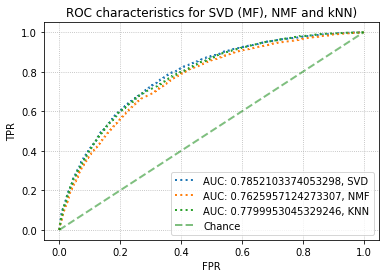

In [37]:
fig, ax = plt.subplots()
thresholded_out = []
for row in res_SVD:
    if row.r_ui > 3:
        thresholded_out.append(1)
    else:
        thresholded_out.append(0)
fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res_SVD])
ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', SVD')  

thresholded_out = []
for row in res_NMF:
    if row.r_ui > 3:
        thresholded_out.append(1)
    else:
        thresholded_out.append(0)
fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res_NMF])
ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', NMF')  

thresholded_out = []
for row in res_KNN:
    if row.r_ui > 3:
        thresholded_out.append(1)
    else:
        thresholded_out.append(0)
fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res_KNN])
ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', KNN')  

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)  
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for SVD (MF), NMF and kNN)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.savefig('Q34.png',dpi=300,bbox_inches='tight')
plt.show()

## Question 13

In [38]:
t = np.arange(1,26,1)
kf = KFold(n_splits=10)

In [39]:
prec_list_knn = []
rec_list_knn = []
for val in t:
    print('Testing for t =',val)
    precision_set = []
    recall_set = []
    for trainset, testset in kf.split(ratings_dataset):
        G = {} #dictionary of movies liked by users
        for row in testset:
            if row[0] in G.keys():
                if row[2] >= 3.0:
                    G[row[0]].add(row[1])
            else:
                G[row[0]] = set()
                if row[2] >= 3.0:
                    G[row[0]].add(row[1])    
        dict_of_items = {} #dictionary of all movies rated by users
        for row in testset:
            if row[0] in dict_of_items.keys():
                dict_of_items[row[0]].append(row[1])
            else:
                dict_of_items[row[0]] = []
                dict_of_items[row[0]].append(row[1])
        mod_testset = [row for row in testset if (len(dict_of_items[row[0]]) >= val and len(G[row[0]]) > 0)]
        res = KNNWithMeans(k=20,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(mod_testset)
        est_rat = {} #dictionary of estimated ratings by users
        for row in res:
            if row[0] in est_rat.keys():
                est_rat[row[0]].append((row[1],row[3]))
            else:
                est_rat[row[0]] = []
                est_rat[row[0]].append((row[1],row[3]))
        precision_u = []
        recall_u = []
        for item in est_rat.keys():
            S_all = est_rat[item]
            S_all = sorted(S_all,key=lambda x:x[1],reverse=True)
            S_t = set([row[0] for row in S_all[0:val]])
            precision_u.append(len(S_t.intersection(G[item]))/float(len(S_t)))
            recall_u.append(len(S_t.intersection(G[item]))/float(len(G[item])))
        precision_set.append(np.mean(precision_u))
        recall_set.append(np.mean(recall_u))
    prec_list_knn.append(np.mean(precision_set))
    rec_list_knn.append(np.mean(recall_set))

Testing for t = 1
Testing for t = 2
Testing for t = 3
Testing for t = 4
Testing for t = 5
Testing for t = 6
Testing for t = 7
Testing for t = 8
Testing for t = 9
Testing for t = 10
Testing for t = 11
Testing for t = 12
Testing for t = 13
Testing for t = 14
Testing for t = 15
Testing for t = 16
Testing for t = 17
Testing for t = 18
Testing for t = 19
Testing for t = 20
Testing for t = 21
Testing for t = 22
Testing for t = 23
Testing for t = 24
Testing for t = 25


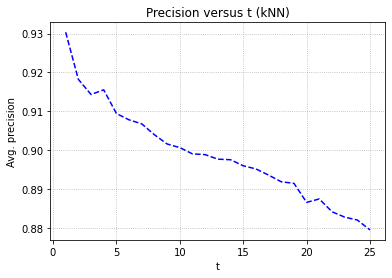

In [40]:
plt.plot(t,prec_list_knn,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('Precision versus t (kNN)')
plt.ylabel('Avg. precision')
plt.xlabel('t')
plt.savefig('Q36a.png',dpi=300,bbox_inches='tight')
plt.show()

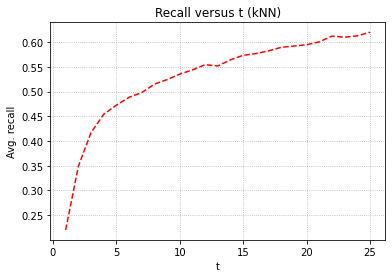

In [41]:
plt.plot(t,rec_list_knn,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('Recall versus t (kNN)')
plt.ylabel('Avg. recall')
plt.xlabel('t')
plt.savefig('Q36b.png',dpi=300,bbox_inches='tight')
plt.show()

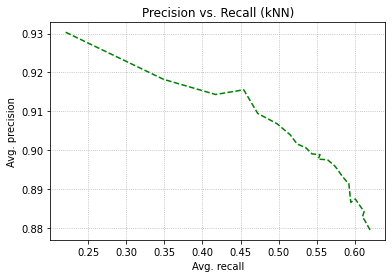

In [42]:
plt.plot(rec_list_knn,prec_list_knn,linestyle='--',color='g')
plt.grid(linestyle=':')
plt.title('Precision vs. Recall (kNN)')
plt.ylabel('Avg. precision')
plt.xlabel('Avg. recall')
plt.savefig('Q36c.png',dpi=300,bbox_inches='tight')
plt.show()

## Question 14

In [43]:
t = np.arange(1,26,1)
kf = KFold(n_splits=10)

In [44]:
prec_list_nmf = []
rec_list_nmf = []
for val in t:
    print('Testing for t =',val)
    precision_set = []
    recall_set = []
    for trainset, testset in kf.split(ratings_dataset):
        G = {} #dictionary of movies liked by users
        for row in testset:
            if row[0] in G.keys():
                if row[2] >= 3.0:
                    G[row[0]].add(row[1])
            else:
                G[row[0]] = set()
                if row[2] >= 3.0:
                    G[row[0]].add(row[1])    
        dict_of_items = {} #dictionary of all movies rated by users
        for row in testset:
            if row[0] in dict_of_items.keys():
                dict_of_items[row[0]].append(row[1])
            else:
                dict_of_items[row[0]] = []
                dict_of_items[row[0]].append(row[1])
        mod_testset = [row for row in testset if (len(dict_of_items[row[0]]) >= val and len(G[row[0]]) > 0)]
        res = NMF(n_factors=16,n_epochs=50,verbose=False).fit(trainset).test(mod_testset)
        est_rat = {} #dictionary of estimated ratings by users
        for row in res:
            if row[0] in est_rat.keys():
                est_rat[row[0]].append((row[1],row[3]))
            else:
                est_rat[row[0]] = []
                est_rat[row[0]].append((row[1],row[3]))
        precision_u = []
        recall_u = []
        for item in est_rat.keys():
            S_all = est_rat[item]
            S_all = sorted(S_all,key=lambda x:x[1],reverse=True)
            S_t = set([row[0] for row in S_all[0:val]])
            precision_u.append(len(S_t.intersection(G[item]))/float(len(S_t)))
            recall_u.append(len(S_t.intersection(G[item]))/float(len(G[item])))
        precision_set.append(np.mean(precision_u))
        recall_set.append(np.mean(recall_u))
    prec_list_nmf.append(np.mean(precision_set))
    rec_list_nmf.append(np.mean(recall_set))

Testing for t = 1
Testing for t = 2
Testing for t = 3
Testing for t = 4
Testing for t = 5
Testing for t = 6
Testing for t = 7
Testing for t = 8
Testing for t = 9
Testing for t = 10
Testing for t = 11
Testing for t = 12
Testing for t = 13
Testing for t = 14
Testing for t = 15
Testing for t = 16
Testing for t = 17
Testing for t = 18
Testing for t = 19
Testing for t = 20
Testing for t = 21
Testing for t = 22
Testing for t = 23
Testing for t = 24
Testing for t = 25


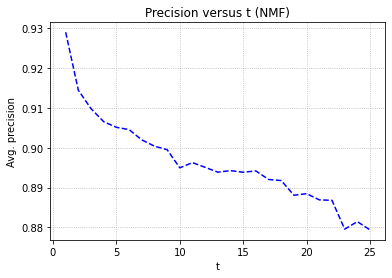

In [45]:
plt.plot(t,prec_list_nmf,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('Precision versus t (NMF)')
plt.ylabel('Avg. precision')
plt.xlabel('t')
plt.savefig('Q37a.png',dpi=300,bbox_inches='tight')
plt.show()

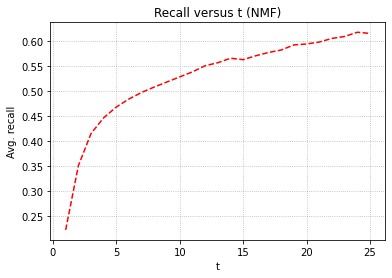

In [46]:
plt.plot(t,rec_list_nmf,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('Recall versus t (NMF)')
plt.ylabel('Avg. recall')
plt.xlabel('t')
plt.savefig('Q37b.png',dpi=300,bbox_inches='tight')
plt.show()

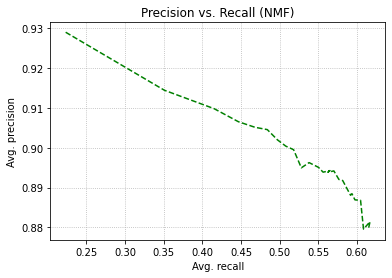

In [47]:
plt.plot(rec_list_nmf,prec_list_nmf,linestyle='--',color='g')
plt.grid(linestyle=':')
plt.title('Precision vs. Recall (NMF)')
plt.ylabel('Avg. precision')
plt.xlabel('Avg. recall')
plt.savefig('Q37c.png',dpi=300,bbox_inches='tight')
plt.show()

In [48]:
t = np.arange(1,26,1)
kf = KFold(n_splits=10)


In [49]:
prec_list_svd = []
rec_list_svd = []
for val in t:
    print('Testing for t =',val)
    precision_set = []
    recall_set = []
    for trainset, testset in kf.split(ratings_dataset):
        G = {} #dictionary of movies liked by users
        for row in testset:
            if row[0] in G.keys():
                if row[2] >= 3.0:
                    G[row[0]].add(row[1])
            else:
                G[row[0]] = set()
                if row[2] >= 3.0:
                    G[row[0]].add(row[1])    
        dict_of_items = {} #dictionary of all movies rated by users
        for row in testset:
            if row[0] in dict_of_items.keys():
                dict_of_items[row[0]].append(row[1])
            else:
                dict_of_items[row[0]] = []
                dict_of_items[row[0]].append(row[1])
        mod_testset = [row for row in testset if (len(dict_of_items[row[0]]) >= val and len(G[row[0]]) > 0)]
        res = SVD(n_factors=22,n_epochs=20,verbose=False).fit(trainset).test(mod_testset)
        est_rat = {} #dictionary of estimated ratings by users
        for row in res:
            if row[0] in est_rat.keys():
                est_rat[row[0]].append((row[1],row[3]))
            else:
                est_rat[row[0]] = []
                est_rat[row[0]].append((row[1],row[3]))
        precision_u = []
        recall_u = []
        for item in est_rat.keys():
            S_all = est_rat[item]
            S_all = sorted(S_all,key=lambda x:x[1],reverse=True)
            S_t = set([row[0] for row in S_all[0:val]])
            precision_u.append(len(S_t.intersection(G[item]))/float(len(S_t)))
            recall_u.append(len(S_t.intersection(G[item]))/float(len(G[item])))
        precision_set.append(np.mean(precision_u))
        recall_set.append(np.mean(recall_u))
    prec_list_svd.append(np.mean(precision_set))
    rec_list_svd.append(np.mean(recall_set))


Testing for t = 1
Testing for t = 2
Testing for t = 3
Testing for t = 4
Testing for t = 5
Testing for t = 6
Testing for t = 7
Testing for t = 8
Testing for t = 9
Testing for t = 10
Testing for t = 11
Testing for t = 12
Testing for t = 13
Testing for t = 14
Testing for t = 15
Testing for t = 16
Testing for t = 17
Testing for t = 18
Testing for t = 19
Testing for t = 20
Testing for t = 21
Testing for t = 22
Testing for t = 23
Testing for t = 24
Testing for t = 25


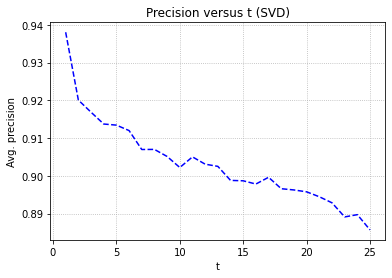

In [50]:
plt.plot(t,prec_list_svd,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('Precision versus t (SVD)')
plt.ylabel('Avg. precision')
plt.xlabel('t')
plt.savefig('Q38a.png',dpi=300,bbox_inches='tight')
plt.show()

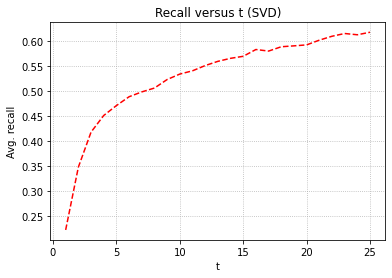

In [51]:
plt.plot(t,rec_list_svd,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('Recall versus t (SVD)')
plt.ylabel('Avg. recall')
plt.xlabel('t')
plt.savefig('Q38b.png',dpi=300,bbox_inches='tight')
plt.show()

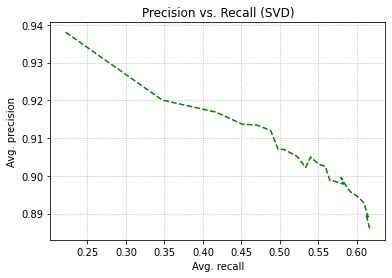

In [52]:
plt.plot(rec_list_svd,prec_list_svd,linestyle='--',color='g')
plt.grid(linestyle=':')
plt.title('Precision vs. Recall (SVD)')
plt.ylabel('Avg. precision')
plt.xlabel('Avg. recall')
plt.savefig('Q38c.png',dpi=300,bbox_inches='tight')
plt.show()

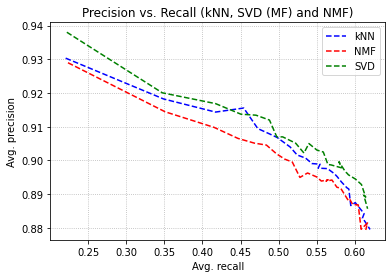

In [53]:
fig, ax = plt.subplots()
ax.plot(rec_list_knn,prec_list_knn,linestyle='--',color='b',label='kNN')
ax.plot(rec_list_nmf,prec_list_nmf,linestyle='--',color='r',label='NMF')
ax.plot(rec_list_svd,prec_list_svd,linestyle='--',color='g',label='SVD')
plt.grid(linestyle=':')
plt.title('Precision vs. Recall (kNN, SVD (MF) and NMF)')
plt.ylabel('Avg. precision')
plt.xlabel('Avg. recall')
plt.legend(loc="best")
plt.savefig('Q39.png',dpi=300,bbox_inches='tight')
plt.show()